In [13]:
import os 
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

In [14]:
class GalaxyZooDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.annotations)*4
    
    def __getitem__(self, index):
        
        real_index, rotate_type = divmod(index, 4)
        
        img_path = os.path.join(self.root_dir, str(self.annotations["GalaxyID"][real_index]) + ".jpg")
        image = io.imread(img_path)
        
        
        x_crop, y_crop = 96, 96
        x_point, y_point = (image.shape[0] - x_crop) // 2, (image.shape[1] - y_crop) // 2
        
        image = image[x_point:x_point + x_crop, y_point:y_point + y_crop]
        x_image = torch.as_tensor(image, dtype=torch.float32)
        
        x_image = torch.rot90(x_image, rotate_type)
        x_image = x_image.permute(2, 0, 1) 
        x_image = x_image.unsqueeze(0)
    
        
        
        y_lable = torch.tensor(self.annotations.iloc[real_index, 1:], dtype=torch.float32)
        
        
        return (x_image, y_lable)


In [15]:
data_res = pd.read_csv("../data/training_solutions_rev1/training_solutions_rev1.csv")
data_res.shape

(61578, 38)

In [16]:
os.path.join("../data/images_training_rev1", "100090" + ".jpg")

'../data/images_training_rev1/100090.jpg'

In [17]:
data_csv = "../data/training_solutions_rev1/training_solutions_rev1.csv"
root_dir = "../data/images_training_rev1"
my_dataset = GalaxyZooDataset(csv_file=data_csv, root_dir=root_dir)
print(my_dataset[0][1])

tensor([0.3831, 0.6169, 0.0000, 0.0000, 0.6169, 0.0385, 0.5784, 0.4184, 0.1985,
        0.0000, 0.1048, 0.5121, 0.0000, 0.0545, 0.9455, 0.2015, 0.1817, 0.0000,
        0.0000, 0.0272, 0.0000, 0.0272, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2800, 0.1384, 0.0000, 0.0000, 0.0929, 0.0000, 0.0000, 0.0000,
        0.3255])


In [18]:
import torch
import torch.nn as nn



In [19]:
class MyCNN(nn.Module):
#     3x96 -5> 16x92 -> 46 -3> 32x44 -> 22 -3> 64x20 -> 10 -3> 128x8 -> 4
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_1 = conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.ReLU(inplace=True)
        )
        
        self.conv_2 = conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        
        self.conv_3 = conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        
        self.conv_4 = conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        
        self.hidden= nn.Sequential(
            nn.Linear(128*4*4, 128), 
            nn.ReLU(inplace=True)
        )
        
        self.drop = nn.Dropout(0.2)
        
        self.out = nn.Sequential(
            nn.Linear(128, 37), 
            nn.ReLU(inplace=True)
        )
        
        
    def forward(self, image):
        
        x1 = self.conv_1(image.float())
        x2 = self.max_pool_2x2(x1)
        x3 = self.conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = x8.view(x8.shape[0], -1)
        x10 = self.hidden(x9)
        x11 = self.drop(x10)
        x = self.out(x11) 
        return x
        
        

In [20]:
if __name__ == "__main__":
    image = torch.rand((1, 3, 96, 96))
    model = MyCNN()
    print(model(image))

tensor([[0.0000, 0.0000, 0.0988, 0.0256, 0.0000, 0.0000, 0.0889, 0.0817, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0525, 0.0000, 0.0104, 0.0000, 0.0045, 0.0000,
         0.0411, 0.0045, 0.0000, 0.0826, 0.0206, 0.0071, 0.0771, 0.0889, 0.0000,
         0.0614, 0.0364, 0.0000, 0.0308, 0.0337, 0.0865, 0.0058, 0.0000, 0.0000,
         0.0154]], grad_fn=<ReluBackward1>)


In [21]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
losses = []

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(10000):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = my_dataset[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            losses.append(running_loss)
            running_loss = 0.0
            
            
print('Finished Training')



[1,   200] loss: 0.040
[1,   400] loss: 0.040
[1,   600] loss: 0.034
[1,   800] loss: 0.037
[1,  1000] loss: 0.031
[1,  1200] loss: 0.034
[1,  1400] loss: 0.034
[1,  1600] loss: 0.031
[1,  1800] loss: 0.031
[1,  2000] loss: 0.031
[1,  2200] loss: 0.031
[1,  2400] loss: 0.030
[1,  2600] loss: 0.031
[1,  2800] loss: 0.028
[1,  3000] loss: 0.035
[1,  3200] loss: 0.029
[1,  3400] loss: 0.027
[1,  3600] loss: 0.023
[1,  3800] loss: 0.022
[1,  4000] loss: 0.030
[1,  4200] loss: 0.030
[1,  4400] loss: 0.027
[1,  4600] loss: 0.025
[1,  4800] loss: 0.025
[1,  5000] loss: 0.024
[1,  5200] loss: 0.029
[1,  5400] loss: 0.028
[1,  5600] loss: 0.029
[1,  5800] loss: 0.027
[1,  6000] loss: 0.026
[1,  6200] loss: 0.027
[1,  6400] loss: 0.026
[1,  6600] loss: 0.023
[1,  6800] loss: 0.021
[1,  7000] loss: 0.030
[1,  7200] loss: 0.024
[1,  7400] loss: 0.027
[1,  7600] loss: 0.027
[1,  7800] loss: 0.026
[1,  8000] loss: 0.024
[1,  8200] loss: 0.024
[1,  8400] loss: 0.024
[1,  8600] loss: 0.022
[1,  8800] 

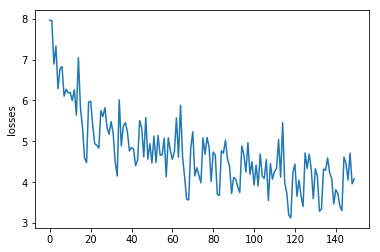

In [24]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('losses')
plt.show()